# Análise de boletins de jurisprudência do TCE-PI

## Introdução
Analisa registros extraídos dos boletins de jurisprudência do TCE/PI a partir de documentos no formato word fornecidos pela Comissão de Regimento e Jurisprudência (CRJ).

Fonte: https://www.tce.pi.gov.br/imprensa/publicacoes/boletins-de-jurisprudencia/
<br>Boletins de agosto de 2017 a agosto de 2020

Cria um modelo usando bag of words e TfIdf do sklearn

Será usado o campo AreaTematica como variável alvo. Porém, nesse dataset só existem 605 registros com 26 àreas temáticas distintas. As maiores são:

| Área Temática       |Qtde| Área Temática       |Qtde|
|---------------------|----|---------------------|----|
| Licitação           | 38 | Contabilidade       | 8  |
| Pessoal             | 35 | Agente Político     | 6  |
| Processual          | 25 | Receita             | 5  |
| Contrato            | 15 | Responsabilidade    | 4  |
| Previdência         | 13 | Transparência       | 3  |
| Educação            | 11 | Convênio e Instrumentos Congêneres    | 3  |
| Câmara Municipal    | 10 | Planejamento                          | 3  |
| Prestação de Contas | 8  | Controle Interno                      | 2  |

Em função da pouca quantidade de registros na maioria das classes, fiz testes usando como alvo as 3 e 5 classes mais frequentes, agrupando as demais como 'Outros'. Também testei usando como variáveis indepentes Ementa e Sumário. **Melhores resultados obtidos foram usando apenas 3 classes alvo e o campo Ementa, com acurácia em torno de 75%**.

Futuro: Analisar com um especialista de domínio a opção de fazer agrupamentos racionais dessas áreas. Usar em torno de 4 ou 5 grupos.

Antonio Filho - 13/09/2020

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

import re
import unicodedata

%matplotlib inline

### Carregar os dados

In [2]:
caminho_dados = Path("../../data/raw/")
df = pd.read_csv(caminho_dados/"boletins_jurisprudencia.csv", sep=";")

In [3]:
df.head()

,Arquivo,Sumario,Ementa,Informacoes,AreaTematica,decisao_tipo,decisao_numero,decisao_ano
0,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,Agente Político. Variação dos subsídios dos ve...,EMENTA. ORÇAMENTO. VARIAÇÃO DOS SUBSÍDIOS DOS ...,(Prestação de Contas. Processo – Relator: Con...,Agente Político,acordao,2400,2017.0
1,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,Câmara Municipal. Elevado dispêndio com diárias.,EMENTA. CÂMARA MUNICIPAL. DESPESA. ELEVADO VAL...,(Prestação de Contas. Processo – Relator: Con...,Câmara Municipal,acordao,2348,2017.0
2,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,Câmara Municipal. Impossibilidade de realizaçã...,EMENTA. CÂMARA MUNICIPAL. IMPOSSIBILIDADE DA R...,(Consulta. Processo – Relator: Cons. Subst. D...,Câmara Municipal,acordao,2711,2017.0
3,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,Contabilidade. Divergência entre o saldo inici...,EMENTA: PRESTAÇÃO DE CONTAS. ENVIO INTEMPESTIV...,(Prestação de Contas. Processo – Relator: Con...,Contabilidade,parecer,267,2017.0
4,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,Contabilidade. Divergência entre o valor da am...,EMENTA: PRESTAÇÃO DE CONTAS. FALHAS DE NATUREZ...,(Prestação de Contas. Processo – Relator: Con...,Contabilidade,parecer,249,2017.0


In [4]:
df.shape

(605, 8)

## Análise exploratória dos dados

In [5]:
# Qtde. de registros por arquivo importado
df.Arquivo.value_counts()

Boletim de Jurisprudência TCE-PI - agosto 2020.docx                                       83
Boletim de Jurisprudência TCE-PI - Agosto-Dezembro - 17 - Consolidação semestral..docx    66
Boletim de Jurisprudência TCE-PI - julho 2020 FINAL.docx                                  58
Boletim de Jurisprudência TCE-PI - Maio - 19.docx                                         31
Boletim de Jurisprudência TCE-PI - Setembro - 18.docx                                     26
Boletim de Jurisprudência TCE-PI - junho 2020.docx                                        23
Boletim de Jurisprudência TCE-PI - junho - 19.docx                                        23
Boletim de Jurisprudência TCE-PI - julho - 19.docx                                        22
Boletim de Jurisprudência TCE-PI - Dezembro-18 (definitivo).docx                          21
Boletim de Jurisprudência TCE-PI - Novembro - 18.docx                                     20
Boletim de Jurisprudência TCE-PI - Janeiro - 18.docx                  

### Análise de áreas temáticas
Verifiquei que há grade variedade de áreas, o que dificulta o trabalho. Vou procurar agrupar.

Essa são as áreas definidas em [RESOLUÇÃO TCE/PI Nº 15, de 14 de agosto de 2017](https://www.tce.pi.gov.br/wp-content/uploads/2017/08/Resolu%C3%A7%C3%A3o-n%C2%BA-15-17-Elabora%C3%A7%C3%A3o-de-ac%C3%B3rd%C3%A3os-e-ementas.pdf)

|                     |  |     |  |   |
|------------------------------------|--------------------|---------------------|---------------------|---|
| Agente Político                    | Assistência Social | Câmara Municipal    | Consórcios Públicos |   |
| Contabilidade                      | Contrato           | Controle Interno    | Controle Social     |   |
| Convênio e Instrumentos Congêneres | Despesa            | Dívida Ativa        | Educação            |   |
| Fundo Especial                     | Licitação          | Orçamento           | Patrimônio          |   |
| Pessoal                            | Planejamento       | Prestação de Contas | Previdência         |   |
| Processual                         | Receita            | Responsabilidade    | Saúde               |   |
| Transparência                      | Tributação         |                     |                     |   |

In [6]:
# Função para normalizar texto, tirando acentuação e colocando em caixa alta
def normalize(text):
    return unicodedata.normalize("NFD", text).encode('ASCII','ignore').decode('ASCII')\
        .strip().upper()

In [7]:
# Qtde. de registros por área temática
print(f'Qtde. de áreas temáticas: {df.AreaTematica.unique().size}')
df.AreaTematica.value_counts()

Qtde. de áreas temáticas: 29


Pessoal                118
Licitação              115
Processual              57
Prestação de Contas     46
Despesa                 38
Responsabilidade        36
Contrato                35
Previdência             28
Saúde                   19
Agente Político         15
Contabilidade           12
Transparência           12
Convênio                11
Receita                 10
Educação                 9
Tributação               9
Câmara Municipal         9
Controle interno         7
FUNDEB                   4
Orçamento                3
Controle Interno         2
FUNDEF                   2
Planejamento             2
Prestação de contas      1
REPRESENTAÇÃO            1
Representação            1
Patrimônio               1
Recurso                  1
Pagamento                1
Name: AreaTematica, dtype: int64

In [8]:
# Normalizar áreas
df.AreaTematica = df.AreaTematica.apply(normalize)

In [9]:
# Qtde. de registros por área temática após normalização
print(f'Qtde. de áreas temáticas após normalização: {df.AreaTematica.unique().size}')
df.AreaTematica.value_counts()

Qtde. de áreas temáticas após normalização: 26


PESSOAL                118
LICITACAO              115
PROCESSUAL              57
PRESTACAO DE CONTAS     47
DESPESA                 38
RESPONSABILIDADE        36
CONTRATO                35
PREVIDENCIA             28
SAUDE                   19
AGENTE POLITICO         15
CONTABILIDADE           12
TRANSPARENCIA           12
CONVENIO                11
RECEITA                 10
EDUCACAO                 9
CAMARA MUNICIPAL         9
CONTROLE INTERNO         9
TRIBUTACAO               9
FUNDEB                   4
ORCAMENTO                3
PLANEJAMENTO             2
REPRESENTACAO            2
FUNDEF                   2
PAGAMENTO                1
PATRIMONIO               1
RECURSO                  1
Name: AreaTematica, dtype: int64

#### Àreas presentes nos boletins que não existem na Resolução

In [10]:
areas_resolucao = ['Agente Político','Assistência Social','Câmara Municipal','Consórcios Públicos',
'Contabilidade','Contrato','Controle Interno','Controle Social',
'Convênio','Despesa','Dívida Ativa','Educação',
'Fundo Especial','Licitação','Orçamento','Patrimônio',
'Pessoal','Planejamento','Prestação de Contas','Previdência',
'Processual','Receita','Responsabilidade','Saúde',
'Transparência','Tributação']
areas_resolucao = [normalize(area) for area in areas_resolucao]

[area for area in set(df.AreaTematica) if area not in areas_resolucao]

['FUNDEB', 'PAGAMENTO', 'REPRESENTACAO', 'FUNDEF', 'RECURSO']

In [11]:
# Alterar algumas áreas
#df.loc[df.AreaTematica.isin(['FUNDEB', 'FUNDEF']), ['AreaTematica']] = 'EDUCACAO'
#df.loc[df.AreaTematica.isin(['PAGAMENTO']), ['AreaTematica']] = 'DESPESA'

# Juntar CONTRATO e CONVENIO
#df.loc[df.AreaTematica.isin(['CONTRATO', 'CONVENIO']), ['AreaTematica']] = 'CONTRATO_CONVENIO'

In [12]:
[area for area in set(df.AreaTematica) if area not in areas_resolucao]

['FUNDEB', 'PAGAMENTO', 'REPRESENTACAO', 'FUNDEF', 'RECURSO']

In [13]:
# Qtde. de registros por área temática após alterações
print(f'Qtde. de áreas temáticas após normalização: {df.AreaTematica.unique().size}')
df.AreaTematica.value_counts()

Qtde. de áreas temáticas após normalização: 26


PESSOAL                118
LICITACAO              115
PROCESSUAL              57
PRESTACAO DE CONTAS     47
DESPESA                 38
RESPONSABILIDADE        36
CONTRATO                35
PREVIDENCIA             28
SAUDE                   19
AGENTE POLITICO         15
CONTABILIDADE           12
TRANSPARENCIA           12
CONVENIO                11
RECEITA                 10
EDUCACAO                 9
CAMARA MUNICIPAL         9
CONTROLE INTERNO         9
TRIBUTACAO               9
FUNDEB                   4
ORCAMENTO                3
PLANEJAMENTO             2
REPRESENTACAO            2
FUNDEF                   2
PAGAMENTO                1
PATRIMONIO               1
RECURSO                  1
Name: AreaTematica, dtype: int64

## Criar modelo para predição de classes

### Importar bibliotecas do scikit Learning

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV  # Busca os melhores parâmetros para o treinamento
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from pprint import pprint
from time import time
import logging

print(__doc__)
# Display progress logs on stdout (Ajuda a entender em que ponto está a execução. Útl para as combinações feitas pelo GridAearch)
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


### Modelo baseado na variável Ementa

In [15]:
Y = df.AreaTematica.apply(lambda x: x \
                          if x in ['PESSOAL', 'LICITACAO', 'PROCESSUAL', 'PRESTACAO DE CONTAS', 'DESPESA', \
                                   'RESPONSABILIDADE', 'PREVIDENCIA'] \
                          else 'OUTROS')

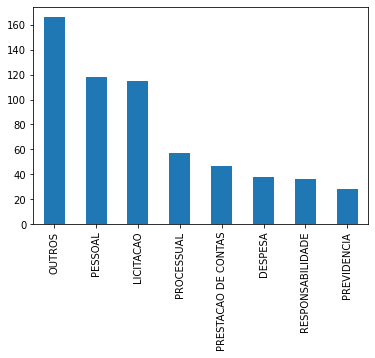

In [16]:
Y.value_counts().plot(kind='bar')

In [17]:
# Usar comando stratif para garantir que o percentual das classe  permaneça nos 2 conjuntos
X_train, X_test, y_train, y_test = \
    train_test_split(df.Ementa, Y, test_size=0.2, stratify=Y, random_state=42)

In [18]:
X_train[:10]

551    ANÁLISE DE PRESTAÇÃO DE CONTAS. IRREGULARIDADE...
148    EMENTA: INCIDENTE PROCESSUAL. FUNDO DE PREVIDÊ...
54     EMENTA. PROCESSUAL. PEDIDO DE ARQUIVAMENTO DE ...
426    REPRESENTAÇÃO. CONTRATAÇÃO DE EMPRESA EMPEDIDA...
440    CÂMARA MUNICIPAL. SUBSÍDIO. IRREGULARIDADE.\n1...
169    DENÚNCIA. LICITAÇÃO. SUPOSTAS IRREGULARIDADES ...
264    CONTAS DO FUNDEB. INDICADOR E LIMITE DO FUNDEB...
603    CONSULTA. LEGALIDADE DE CONTRATAÇÃO, PELO MUNI...
484    AUDITORIA. IRREGULARIDADE QUANTO À SUPERESTIMA...
356    EMBARGOS DE DECLARAÇÃO. NÃO COMPROVAÇÃO DE OBS...
Name: Ementa, dtype: object

In [19]:
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (484,) 
 OUTROS                 0.274793
PESSOAL                0.194215
LICITACAO              0.190083
PROCESSUAL             0.095041
PRESTACAO DE CONTAS    0.078512
DESPESA                0.061983
RESPONSABILIDADE       0.059917
PREVIDENCIA            0.045455
Name: AreaTematica, dtype: float64 

TESTE  :  (121,) 
 OUTROS                 0.272727
PESSOAL                0.198347
LICITACAO              0.190083
PROCESSUAL             0.090909
PRESTACAO DE CONTAS    0.074380
DESPESA                0.066116
RESPONSABILIDADE       0.057851
PREVIDENCIA            0.049587
Name: AreaTematica, dtype: float64


In [20]:
text_train = list(X_train)
text_test = list(X_test)
text_train[:5]

['ANÁLISE DE PRESTAÇÃO DE CONTAS. IRREGULARIDADES IMPUTADOS À SUPERVISORA DO SERVIÇO DE NUTRIÇÃO DA MDER.\nO termo de referência deve conter as especificações e detalhamentos exigidos no art. 6º, inciso IX, Lei nº 8.666/93; ademais a necessidade de aquisição e adequação do objeto licitatório aos interesses da administração devem ser devidamente comprovadas, nos termos do art. 3º, Lei nº 10.520/2002.',
 'EMENTA: INCIDENTE PROCESSUAL. FUNDO DE PREVIDÊNCIA SOCIAL. DESBLOQUEIO DE RECURSOS. APLICAÇÃO DOS PRINCÍPIOS DA RAZOABILIDADE E PROPORCIONALIDADE.\nConsiderando que as verbas bloqueadas têm natureza alimentar e que o Tesouro Municipal não tem condições imediatas de assumir a responsabilidade do pagamento dos proventos dos servidores municipais inativos, reconhece-se a pertinência do pedido do gestor.',
 'EMENTA. PROCESSUAL. PEDIDO DE ARQUIVAMENTO DE TOMADA DE CONTAS ESPECIAL. IMPOSSIBILIDADE.\nO Regimento Interno do TCE-PI, em seu artigo 412, determina que não caberá recurso de decisão 

In [21]:
target_train = list(y_train)
target_test = list(y_test)
print(target_test[:5])

['LICITACAO', 'LICITACAO', 'LICITACAO', 'RESPONSABILIDADE', 'OUTROS']


In [22]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log')), # default hinge. to get proba=log or modified_huber
])

In [23]:
# # uncommenting more parameters will give better exploring power but will
# # increase processing time in a combinatorial way
# parameters = {
#     'vect__max_df': (0.5, 0.75, 1.0),
#     #
#     'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     #
#     'tfidf__use_idf': (True, False),
#     #
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     #
#     'clf__max_iter': (10, 50, 80),
# }

In [24]:
parameters = {
    'vect__max_df': (0.75, 1.0),
    #
    'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    #
    'tfidf__norm': ('l1', 'l2'),
    #'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #
    #'clf__max_iter': (10, 50), Não convergiu
    'clf__max_iter': (10, 50, 100),
}

In [27]:
def modelo(X, y):
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 -> Usar todas as CPUs diponíveis 
    # verbose=1 -> Exibir o que está fazendo
    # cv=3      -> Cross validation em 3 partes
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    
    #grid_search.fit(text_train, target_train)
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return grid_search

In [28]:
grid_search = modelo(text_train, target_train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.9min finished


done in 112.336s

Best score: 0.736
Best parameters set:
	clf__alpha: 1e-06
	clf__max_iter: 100
	clf__penalty: 'l2'
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 2)


In [29]:
grid_search.best_estimator_.predict(text_test)

array(['LICITACAO', 'LICITACAO', 'LICITACAO', 'RESPONSABILIDADE',
       'OUTROS', 'OUTROS', 'OUTROS', 'PROCESSUAL', 'PESSOAL', 'LICITACAO',
       'PESSOAL', 'OUTROS', 'PESSOAL', 'LICITACAO', 'PESSOAL', 'OUTROS',
       'PESSOAL', 'LICITACAO', 'DESPESA', 'LICITACAO', 'OUTROS',
       'PROCESSUAL', 'OUTROS', 'OUTROS', 'OUTROS', 'OUTROS', 'OUTROS',
       'LICITACAO', 'PESSOAL', 'RESPONSABILIDADE', 'PROCESSUAL', 'OUTROS',
       'OUTROS', 'PESSOAL', 'OUTROS', 'OUTROS', 'OUTROS', 'OUTROS',
       'OUTROS', 'LICITACAO', 'PROCESSUAL', 'OUTROS', 'OUTROS',
       'PROCESSUAL', 'LICITACAO', 'OUTROS', 'OUTROS', 'LICITACAO',
       'PESSOAL', 'OUTROS', 'PREVIDENCIA', 'OUTROS', 'OUTROS', 'PESSOAL',
       'PRESTACAO DE CONTAS', 'OUTROS', 'PRESTACAO DE CONTAS',
       'PRESTACAO DE CONTAS', 'OUTROS', 'PESSOAL', 'PESSOAL', 'OUTROS',
       'PROCESSUAL', 'PESSOAL', 'OUTROS', 'OUTROS', 'PESSOAL',
       'LICITACAO', 'OUTROS', 'PESSOAL', 'LICITACAO', 'DESPESA',
       'PREVIDENCIA', 'LICITACAO', 'LIC

In [30]:
prob_preds= grid_search.best_estimator_.predict_proba(text_test)
prob_preds[:10]

array([[0.00713817, 0.94943676, 0.00559293, 0.00541471, 0.00530672,
        0.00364244, 0.00906732, 0.01440094],
       [0.01950611, 0.27450205, 0.24266087, 0.17394182, 0.03228414,
        0.02036632, 0.02703332, 0.20970536],
       [0.01250349, 0.84653546, 0.00503678, 0.00570487, 0.03906056,
        0.00708706, 0.04869518, 0.0353766 ],
       [0.00615122, 0.0422    , 0.02244139, 0.00489143, 0.01386683,
        0.00544695, 0.0038623 , 0.9011399 ],
       [0.11700387, 0.00777386, 0.72182814, 0.11195596, 0.00820345,
        0.01315021, 0.01619687, 0.00388764],
       [0.06797909, 0.03161972, 0.72594203, 0.07750753, 0.0283324 ,
        0.02144549, 0.02937414, 0.01779961],
       [0.01624981, 0.01892107, 0.83657343, 0.03479455, 0.037459  ,
        0.01042133, 0.03305926, 0.01252154],
       [0.00615066, 0.01370799, 0.01955137, 0.01298004, 0.00709237,
        0.01278144, 0.91630571, 0.01143042],
       [0.01016119, 0.0427827 , 0.01534579, 0.89692336, 0.00352582,
        0.01536614, 0.005514

In [31]:
df_test = pd.DataFrame(columns=['texto','area', 'predicted', 'prob_0','prob_1','prob_2','prob_3','prob_4','prob_5'])
df_test['texto'] = text_test
df_test['area'] = target_test
df_test['predicted'] = grid_search.best_estimator_.predict(text_test)
df_test['prob_0'] = prob_preds[0:,0].tolist()
df_test['prob_1'] = prob_preds[0:,1].tolist()
df_test['prob_2'] = prob_preds[0:,2].tolist()
df_test['prob_3'] = prob_preds[0:,3].tolist()
df_test['prob_4'] = prob_preds[0:,4].tolist()
df_test['prob_5'] = prob_preds[0:,5].tolist()

In [32]:
print(df_test.shape)
df_test.head()

(121, 9)


,texto,area,predicted,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5
0,AUDITORIA – P.M. DE CRISTINO CASTRO. ACOMPANHA...,LICITACAO,LICITACAO,0.007138,0.949437,0.005593,0.005415,0.005307,0.003642
1,LICITAÇÕES E CONTRATOS. AUSÊNCIA DO DEVIDO PRO...,LICITACAO,LICITACAO,0.019506,0.274502,0.242661,0.173942,0.032284,0.020366
2,EMENTA. LICITAÇÃO. IRREGULARIDADES EM PREGÃO P...,LICITACAO,LICITACAO,0.012503,0.846535,0.005037,0.005705,0.039061,0.007087
3,PRESTAÇÃO DE CONTAS.\nIrregularidades em licit...,RESPONSABILIDADE,RESPONSABILIDADE,0.006151,0.042200,0.022441,0.004891,0.013867,0.005447
4,CONSTITUCIONAL. ACÚMULO DE CARGOS. PORTAL DA T...,OUTROS,OUTROS,0.117004,0.007774,0.721828,0.111956,0.008203,0.013150


In [33]:
grid_search.best_estimator_.predict(text_test) == target_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
        True,  True, False,  True,  True, False, False,  True,  True,
       False, False, False, False,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True, False,  True,  True])

In [40]:
print(f'Score: {grid_search.best_estimator_.score(text_test, target_test)}')
                
# Avaliar o f1-Score, métrica mais indicada em função dos desbalanceamento das classes
from sklearn.metrics import f1_score
f1_score_val = f1_score(y_test, grid_search.best_estimator_.predict(X_test), average="weighted")                                                
print(f'F1-Score: {f1_score_val}')

Score: 0.6859504132231405
F1-Score: 0.6818045595065655


#### Verificar se faz diferença avaliar os scores usando listas ou diretamente as variáveis do train_test_split

In [42]:
# Inverter(em relação ao teste anteriro) o uso de listas e as varáveis do train_test_split
print(f'Score: {grid_search.best_estimator_.score(X_test, y_test)}')
print(f'F1-Score: {f1_score(target_test, grid_search.best_estimator_.predict(text_test), average="weighted")}')

Score: 0.6859504132231405
F1-Score: 0.6818045595065655


Resultado: deu rigirosamente o mesmo resultado

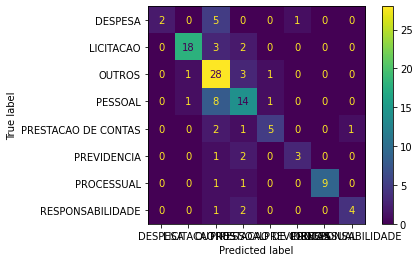

In [35]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

#### Suposições
- Mover PRESTAÇÃO DE CONTAS para OUTROS irá melhorar desempenho, pois o modelo está errando em quase 50%, prevendo OUTROS
- Melhor estratégia para melhorar desempenho será removendo OUTROS

### Testar  PRESTAÇÃO DE CONTAS e  DESPESA como OUTROS

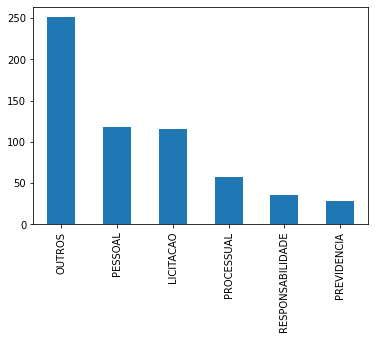

In [36]:
Y = df.AreaTematica.apply(lambda x: x \
                          if x in ['PESSOAL', 'LICITACAO', 'PROCESSUAL', 'RESPONSABILIDADE', 'PREVIDENCIA'] \
                          else 'OUTROS')
Y.value_counts().plot(kind='bar')

In [38]:
# Função para excutar criação do modelo e validar resultados
def model_test(X, Y):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

    text_train = list(X_train)
    text_test = list(X_test)
    target_train = list(y_train)
    target_test = list(y_test)

    grid_search = modelo(text_train, target_train)

    print('Score: ', grid_search.best_estimator_.score(text_test, target_test))
    print('F1-Score: ', f1_score(target_test, grid_search.best_estimator_.predict(text_test), average="weighted"))
    

    plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.7min finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


done in 99.996s

Best score: 0.767
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 10
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 1)
Score:  0.7272727272727273
F1-Score:  0.723178601452312


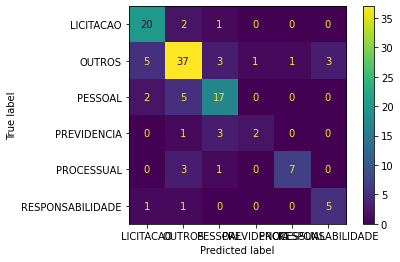

In [39]:
model_test(df.Ementa, Y)

### Testar descartando OUTROS e mantendo as 7 classes usadas anteriormente

In [43]:
df1 = df.copy()

In [44]:
df1.AreaTematica = df1.AreaTematica.apply(lambda x: x \
                          if x in ['PESSOAL', 'LICITACAO', 'PROCESSUAL', 'PRESTACAO DE CONTAS', 'DESPESA', \
                                   'RESPONSABILIDADE', 'PREVIDENCIA'] \
                          else 'OUTROS')

In [45]:
df1.AreaTematica.value_counts()

OUTROS                 166
PESSOAL                118
LICITACAO              115
PROCESSUAL              57
PRESTACAO DE CONTAS     47
DESPESA                 38
RESPONSABILIDADE        36
PREVIDENCIA             28
Name: AreaTematica, dtype: int64

In [46]:
df1 = df1[df1.AreaTematica!='OUTROS']
df1.AreaTematica.value_counts()

PESSOAL                118
LICITACAO              115
PROCESSUAL              57
PRESTACAO DE CONTAS     47
DESPESA                 38
RESPONSABILIDADE        36
PREVIDENCIA             28
Name: AreaTematica, dtype: int64

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  1.3min finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


done in 80.438s

Best score: 0.798
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 10
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 1)
Score:  0.7386363636363636
F1-Score:  0.7328525189980298


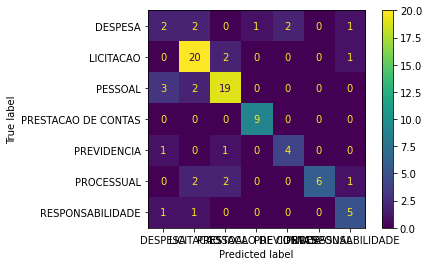

In [47]:
model_test(df1.Ementa, df1.AreaTematica)

### Testar descartando OUTROS e somente com as quatros classes principais

In [48]:
df1.AreaTematica = df1.AreaTematica.apply(lambda x: x \
                          if x in ['PESSOAL', 'LICITACAO', 'PROCESSUAL', 'PRESTACAO DE CONTAS'] \
                          else 'OUTROS')

df1 = df1[df1.AreaTematica!='OUTROS']
df1.AreaTematica.value_counts()

PESSOAL                118
LICITACAO              115
PROCESSUAL              57
PRESTACAO DE CONTAS     47
Name: AreaTematica, dtype: int64

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1.0),
 'vect__max_features': (None, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:   45.1s finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


done in 45.324s

Best score: 0.862
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 10
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: 5000
	vect__ngram_range: (1, 1)
Score:  0.9558823529411765
F1-Score:  0.9558690142723755


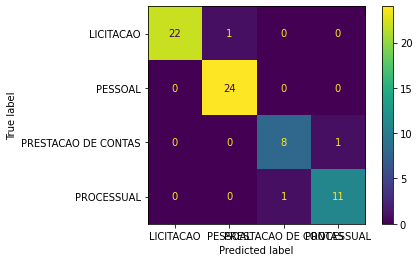

In [49]:
model_test(df1.Ementa, df1.AreaTematica)